# ***Cancer Detection***
## ***Applied Machine Learning W207 Final Project, Fall 2022***
### ***Members***
#### ***1. Chenyu Wang***
#### ***2. Hector Rincon***
#### ***3. Ifrah Javed***
#### ***4. Justin To***
#### ***5. Srila Maiti***

# Introduction

#### 1. This is a notebook showing the running of the final ResNet model presented in Section 4 of the slides.

#### 2. A few points to note:
- This is a copy of the "Batch2" file, containing the notebook that generated the second batch of 8-fold ResNet models.
- Three other batches were also generated, see the other notebooks in Justin's folder.
- The saved model files (h5 files) are not included in the repo due to their large size (~270Mb per file)
- The original notebook was larger and included unused cells inherited from previous notebooks (e.g. code for downloading Kaggle files, EDA cells, etc).  These cells have been cleaned-up and removed for easier reading.
- This file was prepared by Justin To, who ran the notebook on a laptop.  Due to limitations from the size of the VRAM of the GPU, quite a few operations were done by explicitly telling TensorFlow to use CPU + System RAM as opposed to GPU + VRAM
- Sections A-E contain mostly preprocessing cells.  Skip to Section F for the model building and fitting cells.

#### 3. Hardware specification used to run this jupyter notebook:
- CPU: Intel 12th Gen I9-12900H
- System RAM: 32GB (this is needed as memory requirement of the geneator feeding data into ResNet is ~25.7GB in size)
- GPU: Nvidia RTX 3070Ti (Laptop version)
- GPU VRAM: 8 GB

# ***A. Importing the Libraries***

In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold # Added by Justin
from keras.applications.vgg16 import VGG16 #VGG adopted from Srila's code
from sklearn.metrics import roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from keras.layers.convolutional import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import cv2 as cv
import skimage.io as skio

# # Required to read the data from Kaggle
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
tf.__version__

'2.10.0'

# ***B. Support Functionalities***

### ***1. Defining Parameters***

In [3]:
CONTRAST_FACTOR = 3
DELTA = 0.3

train_path = 'train_original/'
test_path = 'test/'

current_working_dir = os.getcwd()

train_label_file = 'train_labels.csv'
test_label_file = 'sample_submission.csv'

image_file_extension = '.tif'

train_files_path = os.path.join(current_working_dir, train_path)
test_files_path = os.path.join(current_working_dir, test_path)

# declare constants for reproduciblity
RANDOM_STATE = 20220922

# Finding split positions
split = (0.30, 0.10, 0.10)

process_chunk_size = 200

tf.random.set_seed(1234)
np.random.seed(1234)

### ***2. Generating Fully Qualified File Name List***
This function generates the list of fully qualified file name list based on the input parameter.

In [4]:
def generate_fully_qualified_file_name_list(file_list):
    """
    This function generates a list of fully qualified file names.
    """
    qualified_file_name_list = [os.path.join(current_working_dir, train_path) + 
                                img + 
                                '.tif' 
                                for img in file_list
                               ]
    return qualified_file_name_list

### ***3. Printing Images in Different Orientation***
This function prints the input imgae in different orientation.

In [5]:
def print_image_in_diff_orientation(image_file):
    """
    This function prints images.
    """
    tf.random.set_seed(1234)
    fig = plt.figure(figsize=(14, 12))
    #fig = plt.figure()
    image = skio.imread(image_file, plugin = "tifffile")
        
    # plot original
    ax = fig.add_subplot(1, 5, 1)
    ax.imshow(array_to_img(image))
    ax.set_title('Original', size=15)

    # resize
    ax = fig.add_subplot(1, 5, 2)
    img_resize = tf.image.resize(image, size=(224, 224))
    ax.imshow(array_to_img(img_resize))
    ax.set_title('Step 1: Resize', size=15)

    # adjust brightness
    ax = fig.add_subplot(1, 5, 3)
    img_bright = tf.image.adjust_brightness(img_resize, 0.3)
    ax.imshow(array_to_img(img_bright))
    ax.set_title('Step 2: Brightness', size=15)

    # adjust contrast
    ax = fig.add_subplot(1, 5, 4)
    img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
    ax.imshow(array_to_img(img_contrast))
    ax.set_title('Step 3: Contrast', size=15)

    # flip left right
    ax = fig.add_subplot(1, 5, 5)
    img_flip = tf.image.flip_left_right(img_contrast)
    ax.imshow(array_to_img(img_flip))
    ax.set_title('Step 4: Flip left right', size=15)

### ***4. Spliting Data in Train, Validation and Test Sets***
This function splits the input data set in train, validation and test data set based on the split indices.

In [6]:
def split_data(split_indices, df):
    """
    This function splits the input dataframe in train, validation and test set.
    """
    X_train = df[: split_indices[0]]
    X_val = df[split_indices[0] : split_indices[1]]
    X_test = df[split_indices[1]:]
    return X_train, X_val, X_test

### ***5. Get IDs and Labels for the Images***
This function gets id and label values for input train and test data set.

In [7]:
def get_id_and_label_list(file_path, file_extension):
    """
    This function gets the imgae id and corresponding label.
    """
    file_list = []
    for file_name in glob.glob(file_path + '*' + file_extension):
        file_list.append(file_name)
    return file_list

### ***6. Read Image File into a Numpy Array***
This function reads each image file in a Numpy array and returns it.

In [8]:
def read_image_file_in_np_array(image_list):
    """
    This function reads each image file in a Numpy array and returns it.
    """
    return np.asarray([skio.imread(image_file, plugin = "tifffile") for image_file in image_list])

### ***7. Converts Numpy Array to Tensor***
This function converts the numpy array representation of an image to a Tensor.

In [9]:
def convert_np_array_to_tensor(np_image_array):
    """
    This function converts the numpy array representation of each image in tensor.
    """
    return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

### ***8. Converting Int Tensor to Float***
This function converts integer TF to Float.

In [10]:
def convert_int_tf_to_float(tf_image_list):
    """
    This function converts integer TF value to float.
    """
    return np.asanyarray([tf.cast(img, tf.float32) for img in tf_image_list])

### ***9. Converting to Grayscale***
This function converts color image to grayscale.

In [11]:
def convert_to_grayscale(tf_image_list):
    """
    This function converts color image to grayscale.
    """
    return tf.image.rgb_to_grayscale(tf_image_list) / 255.0

### ***10. Adjusting Brightness***
This function adjusts brightness of the images. 

In [12]:
def adjust_brightness(tf_image_list, delta):
    """
    This function adjusts the image brightness.
    """
    return tf.image.adjust_brightness(tf_image_list, delta = delta)

### ***11. Adjusting Contrast***
This function adjusts image contrast.

In [13]:
def adjust_contrast(tf_image_list, contrast_factor):
    """
    This function adjusts contrast of the image.
    """
    return tf.image.adjust_contrast(tf_image_list, contrast_factor = contrast_factor)

### ***12. Random Flip Left Right***
This function applies random flip to the image.

In [14]:
def random_flip_left_right(tf_image_list):
    """
    This function applies random flip to the image.
    """
    return tf.image.random_flip_left_right(tf_image_list)

### ***13. Rotate Images 90/180/270 Degrees***
This function rotates images 90/180/270 degrees.

In [15]:
def rotate_image(tf_image_list, k = 1):
    """
    This function rotates images by 90/180/270 degrees.
    k = 1 : 90 degree rotation
    k = 2 : 180 degree rotation
    k = 3 : 270 degree rotation
    """
    return tf.image.rot90(tf_image_list, k)

### ***14. Create Labels***
This function creates labels with 1 or 0.

In [16]:
def create_label(shape, label = 1):
    """
    This function creates labels.
    """
    if label == 1:
        return np.ones(shape).flatten()
    elif label == 0:
        return np.zeros(shape).flatten()

# ***C. Collecting File Information***

### ***1. Get the Image IDs and Corresponding Labels***

There are 220,025 and 57,458 train and test images respectively(tiff 
extension). Each image is 96 X 96 color images (with 3 channels). We are also given train_labels.csv and sample_submission.csv which contain label information for train and test images respectively.

In [17]:
#get file names for train and test
train_file_list = []
test_file_list = []

train_file_list = get_id_and_label_list(train_files_path, image_file_extension)
test_file_list = get_id_and_label_list(test_files_path, image_file_extension)

train_label = pd.read_csv(train_label_file)
test_label = pd.read_csv(test_label_file)

print(f"Number of train files : {len(train_file_list)}")
print(f"Number of test files : {len(test_file_list)}")

Number of train files : 220025
Number of test files : 57458


In [18]:
test_label.label.value_counts()

0    57458
Name: label, dtype: int64

### ***2. Checking for Duplicate IDs***

In [19]:
df_train_id_count = pd.DataFrame(train_label.groupby(['id'])['id'].count())
df_train_id_count.columns = ['id_count']
df_train_id_count.reset_index(inplace = True)
print("Number of train duplicate entries : ", len(df_train_id_count[df_train_id_count.id_count > 1]))

df_test_id_count = pd.DataFrame(test_label.groupby(['id'])['id'].count())
df_test_id_count.columns = ['id_count']
df_test_id_count.reset_index(inplace = True)
print("Number of test duplicate entries : ", len(df_test_id_count[df_test_id_count.id_count > 1]))

Number of train duplicate entries :  0
Number of test duplicate entries :  0


### ***3. Seperating Postive and Negative Images from the Training Data***

In [20]:
train_positive_image_id_list = list(train_label[train_label.label==1].id)
train_negative_image_id_list = list(train_label[train_label.label==0].id)

train_positive_images_list = generate_fully_qualified_file_name_list(train_positive_image_id_list)
train_negative_images_list = generate_fully_qualified_file_name_list(train_negative_image_id_list)

print(f"Number of positive images in train set: {len(train_positive_images_list)}")
print(f"Number of negative images in train set: {len(train_negative_images_list)}")

Number of positive images in train set: 89117
Number of negative images in train set: 130908


# ***D. Data Preprocessing***

### ***1. Shuffling Data***

In [21]:
# Shuffling data
shuffled_train_label = shuffle(train_label)
len_shuffled_train_label = len(shuffled_train_label)

# Selecting positive and negative images from the shuffled list
shuffled_train_positive_label_df = shuffled_train_label[shuffled_train_label.label == 1]
shuffled_train_negative_label_df = shuffled_train_label[shuffled_train_label.label == 0]

print(f"Length of shuffled_train_positive_label_df : {len(shuffled_train_positive_label_df)}")
print(f"Length of shuffled_train_negative_label_df : {len(shuffled_train_negative_label_df)}")

Length of shuffled_train_positive_label_df : 89117
Length of shuffled_train_negative_label_df : 130908


### ***2. Obtaining Split Indices***

In [22]:
split_indices = np.multiply(len(shuffled_train_positive_label_df), split).astype(int)
for idx, val in enumerate(split_indices):
    print(idx, val)
    if idx > 0:
        split_indices[idx] = sum(split_indices[idx - 1 : idx]) + split_indices[idx]
print("Split indecs : ", split_indices)

0 26735
1 8911
2 8911
Split indecs :  [26735 35646 44557]


### ***3. Spliting Data in Train(60%), Validation(20%) and Test(20%) Sets for Both Positive and Negative Images.***
To handle data imbalance problem, we will use equal number of positive and negative images. Thus, we will use 30% train positive, 30% train negative, 10% validation postive, 10% validation negative, 10% test positive and 10% test negative images.

In [23]:
# Splitting data at train, validation and test positions 
# for both positive and negative imgaes
# This process will select the list of ids
(X_train_id_positive, 
 X_val_id_positive, 
 X_test_id_positive) = split_data(split_indices = split_indices, 
                                  df = shuffled_train_positive_label_df[:split_indices[-1]]
                                 )
(X_train_id_negative, 
 X_val_id_negative, 
 X_test_id_negative) = split_data(split_indices = split_indices, 
                                  df = shuffled_train_negative_label_df[:split_indices[-1]]
                                 )
 
print(f"Length of X_train_id_positive : {len(X_train_id_positive)}")
print(f"Length of X_train_id_negative : {len(X_train_id_negative)}")

print(f"Length of X_val_id_positive : {len(X_val_id_positive)}")
print(f"Length of X_val_id_negative : {len(X_val_id_negative)}")

print(f"Length of X_test_id_positive : {len(X_test_id_positive)}")
print(f"Length of X_test_id_negative : {len(X_test_id_negative)}")

Length of X_train_id_positive : 26735
Length of X_train_id_negative : 26735
Length of X_val_id_positive : 8911
Length of X_val_id_negative : 8911
Length of X_test_id_positive : 8911
Length of X_test_id_negative : 8911


### ***4. Generating Fully Qualified Image File Name List for Both Positive and Negative Images***

In [24]:
X_train_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_train_id_positive[['id']].values.tolist()).flat))
X_val_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_val_id_positive[['id']].values.tolist()).flat))
X_test_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_test_id_positive[['id']].values.tolist()).flat))

X_train_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_train_id_negative[['id']].values.tolist()).flat))
X_val_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_val_id_negative[['id']].values.tolist()).flat))
X_test_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_test_id_negative[['id']].values.tolist()).flat))

print(f"Length of X_train_img_file_positive : {len(X_train_img_file_positive)}")
print(f"Length of X_train_img_file_negative : {len(X_train_img_file_negative)}")

print(f"Length of X_val_img_file_positive : {len(X_val_img_file_positive)}")
print(f"Length of X_val_img_file_negative : {len(X_val_img_file_negative)}")

print(f"Length of X_test_img_file_positive : {len(X_test_img_file_positive)}")
print(f"Length of X_test_img_file_negative : {len(X_test_img_file_negative)}")

Length of X_train_img_file_positive : 26735
Length of X_train_img_file_negative : 26735
Length of X_val_img_file_positive : 8911
Length of X_val_img_file_negative : 8911
Length of X_test_img_file_positive : 8911
Length of X_test_img_file_negative : 8911


### ***5. Reading Image File in Numpy Array***

In [26]:
# This process will read each image file and store them in np array
# for both positive and negative images
X_train_positive_np = read_image_file_in_np_array(X_train_img_file_positive)
X_val_positive_np = read_image_file_in_np_array(X_val_img_file_positive)
X_test_positive_np = read_image_file_in_np_array(X_test_img_file_positive)

X_train_negative_np = read_image_file_in_np_array(X_train_img_file_negative)
X_val_negative_np = read_image_file_in_np_array(X_val_img_file_negative)
X_test_negative_np = read_image_file_in_np_array(X_test_img_file_negative)

print(f"Shape of X_train_positive_np : {X_train_positive_np.shape}")
print(f"Shape of X_train_negative_np : {X_train_negative_np.shape}")

print(f"Shape of X_val_positive_np : {X_val_positive_np.shape}")
print(f"Shape of X_val_negative_np : {X_val_negative_np.shape}")

print(f"Shape of X_test_positive_np : {X_test_positive_np.shape}")
print(f"Shape of X_test_negative_np : {X_test_negative_np.shape}")

Shape of X_train_positive_np : (26735, 96, 96, 3)
Shape of X_train_negative_np : (26735, 96, 96, 3)
Shape of X_val_positive_np : (8911, 96, 96, 3)
Shape of X_val_negative_np : (8911, 96, 96, 3)
Shape of X_test_positive_np : (8911, 96, 96, 3)
Shape of X_test_negative_np : (8911, 96, 96, 3)


### ***6. Converting Numpy Array to Tensor***

In [27]:
# This process converts np array to tensor
# for both positive and negative images
with tf.device('/cpu:0'):
    X_train_positive_tf = convert_np_array_to_tensor(X_train_positive_np)
    X_val_positive_tf = convert_np_array_to_tensor(X_val_positive_np)
    X_test_positive_tf = convert_np_array_to_tensor(X_test_positive_np)

    X_train_negative_tf = convert_np_array_to_tensor(X_train_negative_np)
    X_val_negative_tf = convert_np_array_to_tensor(X_val_negative_np)
    X_test_negative_tf = convert_np_array_to_tensor(X_test_negative_np)

print(f"Shape of X_train_positive_tf : {X_train_positive_tf.shape}")
print(f"Shape of X_train_negative_tf : {X_train_negative_tf.shape}")

print(f"Shape of X_val_positive_tf : {X_val_positive_tf.shape}")
print(f"Shape of X_val_negative_tf : {X_val_negative_tf.shape}")

print(f"Shape of X_test_positive_tf : {X_test_positive_tf.shape}")
print(f"Shaepe of X_test_negative_tf : {X_test_negative_tf.shape}")

Shape of X_train_positive_tf : (26735, 96, 96, 3)
Shape of X_train_negative_tf : (26735, 96, 96, 3)
Shape of X_val_positive_tf : (8911, 96, 96, 3)
Shape of X_val_negative_tf : (8911, 96, 96, 3)
Shape of X_test_positive_tf : (8911, 96, 96, 3)
Shaepe of X_test_negative_tf : (8911, 96, 96, 3)


### ***7. Creating Labels***

#### ***a. Creating Positive Labels***

In [30]:
Y_train_positive = create_label(len(X_train_positive_tf))
Y_val_positive = create_label(len(X_val_positive_tf))
Y_test_positive = create_label(len(X_test_positive_tf))

#### ***b. Creating Negative Labels***

In [31]:
Y_train_negative = create_label(len(X_train_negative_tf), 0)
Y_val_negative = create_label(len(X_val_negative_tf), 0)
Y_test_negative = create_label(len(X_test_negative_tf), 0)

# ***E. Image Processing***

### ***1. Converting Color Images to Grayscale***

In [32]:
with tf.device('/cpu:0'):
    print("Handling grayscale conversion for X_train_positive_tf")
    X_train_positive_tf = convert_to_grayscale(X_train_positive_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    print("Handling grayscale conversion for X_val_positive_tf")
    X_val_positive_tf = convert_to_grayscale(X_val_positive_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    print("Handling grayscale conversion for X_test_positive_tf")
    X_test_positive_tf = convert_to_grayscale(X_test_positive_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    print("Handling grayscale conversion for X_train_negative_tf")
    X_train_negative_tf = convert_to_grayscale(X_train_negative_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    print("Handling grayscale conversion for X_val_negative_tf")
    X_val_negative_tf = convert_to_grayscale(X_val_negative_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    print("Handling grayscale conversion for X_test_negative_tf")
    X_test_negative_tf = convert_to_grayscale(X_test_negative_tf)
    gc.collect()
    tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_tf : {X_train_positive_tf.shape}")
print(f"Shape of X_train_negative_tf : {X_train_negative_tf.shape}")

print(f"Shape of X_val_positive_tf : {X_val_positive_tf.shape}")
print(f"Shape of X_val_negative_tf : {X_val_negative_tf.shape}")

print(f"Shape of X_test_positive_tf : {X_test_positive_tf.shape}")
print(f"Shape of X_test_negative_tf : {X_test_negative_tf.shape}")

Handling grayscale conversion for X_train_positive_tf
Handling grayscale conversion for X_val_positive_tf
Handling grayscale conversion for X_test_positive_tf
Handling grayscale conversion for X_train_negative_tf
Handling grayscale conversion for X_val_negative_tf
Handling grayscale conversion for X_test_negative_tf
Shape of X_train_positive_tf : (26735, 96, 96, 1)
Shape of X_train_negative_tf : (26735, 96, 96, 1)
Shape of X_val_positive_tf : (8911, 96, 96, 1)
Shape of X_val_negative_tf : (8911, 96, 96, 1)
Shape of X_test_positive_tf : (8911, 96, 96, 1)
Shape of X_test_negative_tf : (8911, 96, 96, 1)


### ***2. Blending Positive and Negative Data***
*(Blending data first and do image processing during the K-fold process)*

In [33]:
with tf.device('/cpu:0'):
    X_train = tf.concat([X_train_positive_tf , X_train_negative_tf] , axis = 0)
    X_val = tf.concat([X_val_positive_tf , X_val_negative_tf] , axis = 0)
    X_test = tf.concat([X_test_positive_tf , X_test_negative_tf] , axis = 0)

    y_train = tf.concat([Y_train_positive , Y_train_negative] , axis = 0)
    y_val = tf.concat([Y_val_positive , Y_val_negative] , axis = 0)
    y_test = tf.concat([Y_test_positive , Y_test_negative] , axis = 0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (53470, 96, 96, 1)
y_train shape: (53470,)
X_val shape: (17822, 96, 96, 1)
y_val shape: (17822,)
X_test shape: (17822, 96, 96, 1)
y_test shape: (17822,)


### ***3. Shuffling the Images***
*(Shuffling data first and do image processing during the K-fold process)*

#### ***a. Shuffling the Train Data***

In [34]:
with tf.device('/cpu:0'):
    print("Shuffling the train data")
    train_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype = tf.int32))
    X_train = tf.gather(X_train, train_shuffle_indices)
    y_train = tf.gather(y_train, train_shuffle_indices).numpy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Shuffling the train data
X_train shape: (53470, 96, 96, 1)
y_train shape: (53470,)


#### ***b. Shuffling the Validation Data***

In [35]:
with tf.device('/cpu:0'):
    print("Shuffling the validation data")
    val_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_val)[0], dtype = tf.int32))
    X_val = tf.gather(X_val, val_shuffle_indices)
    y_val = tf.gather(y_val, val_shuffle_indices).numpy()

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Shuffling the validation data
X_val shape: (17822, 96, 96, 1)
y_val shape: (17822,)


#### ***c. Shuffling the Test Data***

In [36]:
with tf.device('/cpu:0'):
    print("Shuffling the test data")
    test_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_test)[0], dtype = tf.int32))
    X_test = tf.gather(X_test, test_shuffle_indices)
    y_test = tf.gather(y_test, test_shuffle_indices).numpy()

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Shuffling the test data
X_test shape: (17822, 96, 96, 1)
y_test shape: (17822,)


# ***F. Model Building & Fitting***

### F.1 Recombining the train and validation data for k-fold validation

In [38]:
# Recombining the train and validation sets
with tf.device('/cpu:0'):
    X_train_kfold = tf.concat([X_train, X_val] , axis = 0)
    y_train_kfold = tf.concat([y_train, y_val] , axis = 0)

    print("Shuffling the kfold train data...")
    tf.random.set_seed(1234) # for reproducibility
    
    test_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_train_kfold)[0], dtype = tf.int32))
    X_train_kfold = tf.gather(X_train_kfold, test_shuffle_indices)
    y_train_kfold = tf.gather(y_train_kfold, test_shuffle_indices).numpy()

print(f"X_train_kfold shape: {X_train_kfold.shape}")
print(f"y_train_kfold shape: {y_train_kfold.shape}")

Shuffling the kfold train data...
X_train_kfold shape: (71292, 96, 96, 1)
y_train_kfold shape: (71292,)


In [39]:
# Testing out the stratified K-fold function to make sure the folds are balanced.

print(f"The percentage of positive labels in y_train_kfold: {len(y_train_kfold[y_train_kfold==1])/len(y_train_kfold)}")

n_splits = 8

for kfold, (train, validation) in enumerate(StratifiedKFold(n_splits=n_splits,
                                                            shuffle=True).split(X_train_kfold, y_train_kfold)):
    temp_train, temp_val = y_train_kfold[train], y_train_kfold[validation] 
    print(f"\n---Iteration: {kfold + 1}---")
    print(f"The percentage of positive labels in training set: {len(temp_train[temp_train==1])/len(temp_train)}")
    print(f"The percentage of positive labels in validation set: {len(temp_val[temp_val==1])/len(temp_val)}")


The percentage of positive labels in y_train_kfold: 0.5

---Iteration: 1---
The percentage of positive labels in training set: 0.5
The percentage of positive labels in validation set: 0.5

---Iteration: 2---
The percentage of positive labels in training set: 0.5
The percentage of positive labels in validation set: 0.5

---Iteration: 3---
The percentage of positive labels in training set: 0.5
The percentage of positive labels in validation set: 0.5

---Iteration: 4---
The percentage of positive labels in training set: 0.5
The percentage of positive labels in validation set: 0.5

---Iteration: 5---
The percentage of positive labels in training set: 0.5000080152610571
The percentage of positive labels in validation set: 0.499943889574683

---Iteration: 6---
The percentage of positive labels in training set: 0.5000080152610571
The percentage of positive labels in validation set: 0.499943889574683

---Iteration: 7---
The percentage of positive labels in training set: 0.49999198473894296
The

In [40]:
len(y_train_kfold[y_train_kfold==1])/len(y_train_kfold)

0.5

### F.2 Adding a printing helper function and custom generator class for larger networks

In [41]:
# Defining a helper function for evaluating accuracy

def plot_model_eval(loss, val_loss, accuracy, val_accuracy, show_std=True):
    """
    Helper function to print out the accuracy and loss graphs based on model history for k-fold validation
    
    Args:
        loss: list of lists containing losses from multiple histories.
        accuracy: list of lists containing accuracies from multiple histories.
        val_loss: list of lists containing validation loss from multiple histories.
        val_accuracy: list of lists containing validation accuracies from multiple histories.
        show_std: whether to show the region of mean +/- std.  Defaulted to True.
    """
    # Calculating the mean values
    loss_mean = np.mean(np.array(loss), axis=0)
    val_loss_mean = np.mean(np.array(val_loss), axis=0)
    acc_mean = np.mean(np.array(accuracy), axis=0)
    val_acc_mean = np.mean(np.array(val_accuracy), axis=0)
    
    # Calculating the standard deviation values
    loss_std = np.std(np.array(loss), axis=0)
    val_loss_std = np.std(np.array(val_loss), axis=0)
    acc_std = np.std(np.array(accuracy), axis=0)
    val_acc_std = np.std(np.array(val_accuracy), axis=0)
    
    x_arr = np.arange(len(loss_mean)) + 1

    fig = plt.figure(figsize=(12, 4))
    
    # Plotting the loss graph
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, loss_mean, '-o', label='Train loss')
    ax.plot(x_arr, val_loss_mean, '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    
    # Show std range of losses
    if show_std:
        ax.fill_between(x_arr,
                       loss_mean + loss_std,
                       loss_mean - loss_std,
                       alpha=0.15, color='blue')
        ax.fill_between(x_arr,
                       val_loss_mean + val_loss_std,
                       val_loss_mean - val_loss_std,
                       alpha=0.15, color='orange')

    # Plotting the accuracy graph    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(x_arr, acc_mean, '-o', label = 'Train acc.')
    ax2.plot(x_arr, val_acc_mean, '--<', label = 'Validation acc.')
    ax2.legend(fontsize=15)
    ax2.set_xlabel('Epoch', size = 15)
    ax2.set_ylabel('Accuracy', size = 15)
    ax2.set_ylim(0,1)
    
    # Show std range of accuracies
    if show_std:
        ax2.fill_between(x_arr,
                       acc_mean + acc_std,
                       acc_mean - acc_std,
                       alpha=0.15, color='blue')
        ax2.fill_between(x_arr,
                       val_acc_mean + val_acc_std,
                       val_acc_mean - val_acc_std,
                       alpha=0.15, color='orange')
    
    plt.show()

In [42]:
# Adopted from the Medium article "Training on Large Datasets That Don’t Fit In Memory in Keras"
# Source: medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, images, labels, batch_size) :
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    
    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
  
  
    def __getitem__(self, idx) :
        with tf.device('/cpu:0'): 
            batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
            batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
        return batch_x, batch_y

### F.3 - Running the ResNet Model

In [44]:
def build_ResNet():
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    input_shape = (96, 96, 3)
    
    rnet50 = tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=input_shape)

    inputs = tf.keras.Input(input_shape)
    m2 = tf.keras.layers.GlobalAveragePooling2D()(rnet50(inputs))
    m2 = tf.keras.layers.Dropout(.1)(m2)
    m2 = tf.keras.layers.Flatten()(m2)
    m2 = tf.keras.layers.Dense(1, activation= None)(m2)

    resnetmodel = tf.keras.Model(inputs=inputs, outputs=m2)
    resnetmodel.compile(optimizer = 'adam',
                        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics = ['accuracy']) 
    
    return resnetmodel  

Doing fold 1 of 8...

- Step 1(a) - brightness adjustment..

- Step 1(b) - contrast adjustment..

- Step 1(c) - random flips..

- Step 1(d) - 90 rotations..

- Step 1(e) - 180 rotations..

- Step 1(f) - 270 rotations..

- Step 1(g) - merging images back..

- Preprocessing Done!
Epoch 1/10
7797/7797 [==============================] - 452s 56ms/step - loss: 0.3193 - accuracy: 0.8603 - val_loss: 0.3228 - val_accuracy: 0.8472
Epoch 2/10
7797/7797 [==============================] - 438s 56ms/step - loss: 0.2439 - accuracy: 0.8981 - val_loss: 0.2911 - val_accuracy: 0.8689
Epoch 3/10
7797/7797 [==============================] - 439s 56ms/step - loss: 0.2075 - accuracy: 0.9159 - val_loss: 0.8928 - val_accuracy: 0.6660
Epoch 4/10
7797/7797 [==============================] - 478s 61ms/step - loss: 0.1804 - accuracy: 0.9279 - val_loss: 0.2247 - val_accuracy: 0.9165
Epoch 5/10
7797/7797 [==============================] - 466s 60ms/step - loss: 0.1558 - accuracy: 0.9382 - val_loss: 0.3065 - val_acc

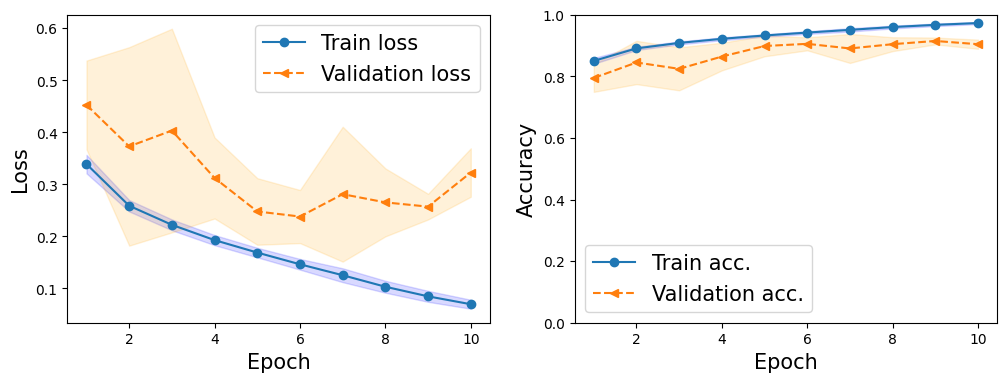

In [46]:
CONTRAST_FACTOR = 3  # This is unused
DELTA = 0.3          # This is unused

n_splits = 8
batch_size = 32

loss, val_loss, accuracy, val_accuracy = [], [], [], []


for kfold, (train, validation) in enumerate(StratifiedKFold(n_splits=n_splits,
                                                            shuffle=True).split(X_train_kfold, y_train_kfold)):

    print(f"Doing fold {kfold+1} of {n_splits}...")

    with tf.device('/cpu:0'):
        train_data = tf.gather(X_train_kfold, train)
        validation_data = tf.gather(X_train_kfold, validation)
        
        ## Added in 28-Oct version: image augmentation:
        
        # Brightness - In fact unused, as Step 1(c) uses the original train_data rather than train_data_aug from this step
        print("\n- Step 1(a) - brightness adjustment..")
        train_data_aug = adjust_brightness(train_data, delta = DELTA)
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Contrast - In fact unused, as Step 1(c) uses the original train_data rather than train_data_aug from this step
        print("\n- Step 1(b) - contrast adjustment..")
        train_data_aug = adjust_contrast(train_data, contrast_factor = CONTRAST_FACTOR)
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Random Flip - apply to original as well
        print("\n- Step 1(c) - random flips..")
        train_data_aug = random_flip_left_right(train_data)
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Raotations 90 - new images created
        print("\n- Step 1(d) - 90 rotations..")
        train_data_aug_90 = rotate_image(train_data_aug)
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Raotations 180 - new images created
        print("\n- Step 1(e) - 180 rotations..")
        train_data_aug_180 = rotate_image(train_data_aug, k=2)
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Raotations 270 - new images created
        print("\n- Step 1(f) - 270 rotations..")
        train_data_aug_270 = rotate_image(train_data_aug, k=3)
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Merging new images
        print("\n- Step 1(g) - merging images back..")
        train_data_aug = tf.concat([train_data,
                                       train_data_aug_90,
                                       train_data_aug_180,
                                       train_data_aug_270],
                                      axis = 0)
        y_train_kfold_aug = tf.concat([y_train_kfold[train],
                                      y_train_kfold[train],
                                      y_train_kfold[train],
                                      y_train_kfold[train]],
                                      axis = 0)
        gc.collect()
        tf.keras.backend.clear_session()
        
        print("\n- Preprocessing Done!")
    
    # instantiate the model
    model = build_ResNet()
    
    with tf.device('/cpu:0'):
        try:
            del training_batch_generator
        except:
            None
        try:
            del validation_batch_generator
        except:
            None
        
        gc.collect()
        
        training_batch_generator = My_Custom_Generator(np.repeat(train_data_aug, 3, -1),
                                                       y_train_kfold_aug,
                                                       batch_size)
        validation_batch_generator = My_Custom_Generator(np.repeat(validation_data, 3, -1),
                                                         y_train_kfold[validation],
                                                         batch_size)
    
    # run the model 
    history = model.fit(training_batch_generator,
                        steps_per_epoch = int(train_data_aug.shape[0] // batch_size),
                        epochs = 10,
                        verbose = 1,
                        validation_data = validation_batch_generator,
                        validation_steps = int(validation_data.shape[0] // batch_size))
    
    # adding some of the mertics we need    
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    accuracy.append(history.history['accuracy'])
    val_accuracy.append(history.history['val_accuracy'])
    
    # save the model and clear garbage
    model_name = f"ResNet_Batch2_Fold{kfold+1}_Justin.h5"
    
    model.save(model_name)
    
    gc.collect()
    
plot_model_eval(loss, val_loss, accuracy, val_accuracy, show_std=True) 

### F.4 - Evaluating the ResNet Model

In [47]:
# saving the losses and accuracies
d = {'Loss': loss,
     'Val_loss': val_loss,
     'Acc': accuracy,
     'Val_acc': val_accuracy}
loss_df = pd.DataFrame(data=d)

loss_df.to_csv('Batch2_Loss_Values.csv', index=True)

In [48]:
def ensemble_voting_binary(model_list, X_test):
    '''
    Custom function to have an ensemble of pre-saved models voting on the results.
    Assumes (i) the models return logits; (ii) binary classification task.
    ----
    Params:
    model_list: list of model names to load
    X_test: features to be fed into the models for predictions
    ----
    Return:
    final_vote: array for comparing against y_test
    '''
    total_probas = np.zeros(shape=(len(model_list), X_test.shape[0]))
    total_votes = np.zeros(shape=(len(model_list), X_test.shape[0]))
    
    for idx, model_name in enumerate(model_list):
        # load model
        model = tf.keras.models.load_model(model_name)
        
        # predict logits
        pred_logits_model = model.predict(X_test)
        probas_model = tf.sigmoid(pred_logits_model)
        probas_model = probas_model.numpy().flatten()*100
        
        # convert to predictions
        preds_model = [1 if x>50.0 else 0 for x in probas_model]
        
        # append the predictions and probabilities to the total_probas and total_votes
        total_probas[idx] = probas_model
        total_votes[idx] = preds_model
        
        gc.collect()
    
    # calculating averages across the model predictions
    average_probas = np.mean(total_probas, axis=0)
    average_votes = np.mean(total_votes, axis=0)
    
    # in case of a tie in votes, looks at the mean probability
    final_vote = [1 if x>0.5 else (1 if (x==0.5 and average_probas[idx]>50.0) else 0) for idx, x in enumerate(average_votes)]
    
    return final_vote        

557/557 [==============================] - 8s 13ms/step
ROC AUC Score =  0.9419257097968802


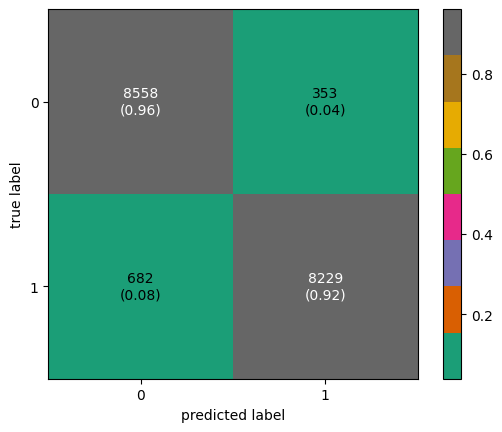

In [49]:
model_list = ['ResNet_Batch2_Fold1_Justin.h5', 'ResNet_Batch2_Fold2_Justin.h5',
              'ResNet_Batch2_Fold3_Justin.h5', 'ResNet_Batch2_Fold4_Justin.h5',
              'ResNet_Batch2_Fold5_Justin.h5', 'ResNet_Batch2_Fold6_Justin.h5',
              'ResNet_Batch2_Fold7_Justin.h5', 'ResNet_Batch2_Fold8_Justin.h5']
X_test_threechannels = np.repeat(X_test, 3, -1)

predictions_ensemble = np.array(ensemble_voting_binary(model_list, X_test_threechannels))
confusion_matrix_ensemble = confusion_matrix(np.ceil(y_test).astype(int), predictions_ensemble)

#plot_confusion_matrix(confusion_matrix_cnn_3, ['Cancer', 'No Cancer'])
print('ROC AUC Score = ',roc_auc_score(np.ceil(y_test).astype(int), predictions_ensemble))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_ensemble,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap = 'Dark2')
plt.show()

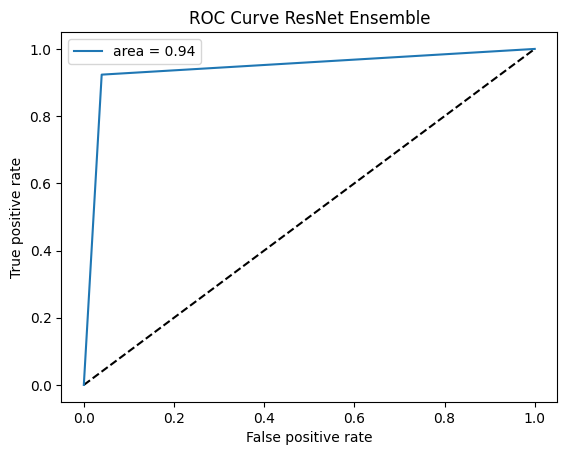

In [50]:
### NOTE: THIS IS A WRONG IMPLEMENTATION OF THE AUC FUNCTION ###
### The correct one is in the file "J10_Comparing_Contrast_Models.ipynb".
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(np.ceil(y_test).astype(int), predictions_ensemble)
auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ensemble, tpr_ensemble, label='area = {:.2f}'.format(auc_ensemble))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve ResNet Ensemble')
plt.legend(loc='best')
plt.show()